In [1]:
import tensorflow as tf
import prettytensor as pt
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import os, sys
from PIL import Image
from scipy.misc import imread
import glob
from tqdm import tqdm_notebook

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

In [6]:
# HYPERPARAMETERS
DATABASE_DIR = "./data/LL-Net/"
SAVE_DIR = "./checkpoints/"
DATABASE_SIZE = 56

# IMAGE KERNEL DESCRIPTORS
IMAGE_SIZE = 17
NUM_CHANNELS = 1

In [7]:
# IMAGE MANIPULATION FUNCTIONS
def clamp (n, minn, maxn):
    return max(min(maxn, n), minn)

def clamp_arr(n, minn, maxn):
    for i in xrange(len(n)):
        n[i] = max(min(maxn, n[i]), minn)
    return n

def crop_img(img, start_y=0, start_x=0):
    # Remove negative vals
    start_y = 0 if start_y < 0 else start_y
    start_x = 0 if start_x < 0 else start_x 
    
    # Remove overflows
    start_y = img.shape[0] - IMAGE_SIZE - 1 if start_y+IMAGE_SIZE >= img.shape[0] else start_y
    start_x = img.shape[1] - IMAGE_SIZE - 1 if start_x+IMAGE_SIZE >= img.shape[1] else start_x 
    
    return img[start_y:(start_y+IMAGE_SIZE), start_x:(start_x+IMAGE_SIZE)]

def transform_img(img, rot=0, lr=0, ud=0):
    img = np.rot90(img, rot)
    if lr == 1: img = np.fliplr(img)
    if ud == 1: img = np.flipud(img)
    return img

def adjust_gamma(img, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def adjust_hsv(img, h=0, s=0, v=0):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for x in range(0, len(hsv)):
        for y in range(0, len(hsv[0])):
            hsv[x, y][2] = hsv[x, y][2]-v if hsv[x, y][2]>v else 0  
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def add_noise(img, mu=0,sig=1):
    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            noise = np.random.normal(mu,sig,3)
            img[x,y][0] = clamp(img[x,y][0] + noise[0],0,255)
            img[x,y][1] = clamp(img[x,y][1] + noise[1],0,255)
            img[x,y][2] = clamp(img[x,y][2] + noise[2],0,255)
    return img

def add_bw_noise(img, mu=0,sig=1):
    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            noise = np.random.normal(mu,sig)
            img[x,y] = clamp(img[x,y] + noise,0,255)
    return img

def add_1d_bw_noise(img, mu=0,sig=1):
    noise = np.random.normal(mu,sig,len(img))
    img = clamp_arr(img+noise,0,255)
    return img

def plot_images(images, smooth=True):
    assert len(images) == 9
    fig, axes = plt.subplots(3, 3)
    hspace = 0.3
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        ax.imshow(images[i], interpolation=interpolation, cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

255

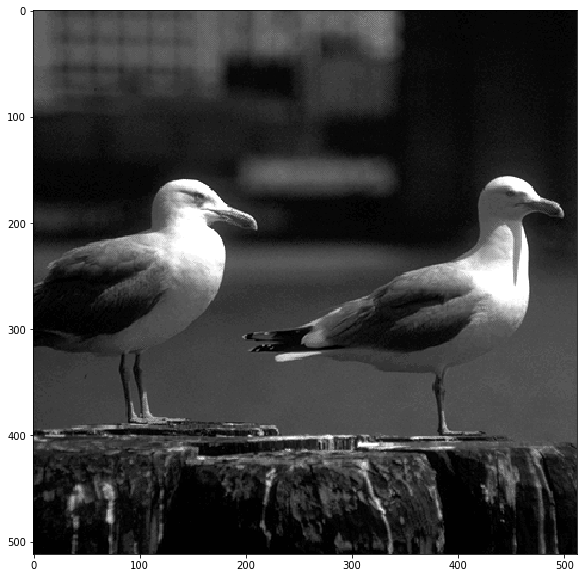

In [8]:
img=imread('./data/LL-Net/1.pgm')
plt.imshow(adjust_gamma(img, 1), cmap="gray")
img.max()

In [9]:
# Load all images in database
# for filename in glob.glob(DATABASE_DIR+"*.pgm"): #assuming pgm
def create_training_batch(BATCH_COUNTER):
    ground_database     = []
    noisy_database      = []
    dark_noisy_database = []

    BATCH_COUNTER += 1
    img = imread(DATABASE_DIR + str(BATCH_COUNTER) + ".pgm")
    print("Creating batch from image:"+DATABASE_DIR+str(BATCH_COUNTER)+".pgm")
    
    max_x = int((img.shape[0] - IMAGE_SIZE)/3)*3
    max_y = int((img.shape[1] - IMAGE_SIZE)/3)*3
    
    for x in tqdm_notebook(xrange(0,max_x+1,3)):
        for y in xrange(0,max_y+1,3):
            cropped_img = crop_img(img, x,y)
            ground_database.append(np.matrix(np.ravel(cropped_img)) )
            # TODO: Apply transformations to create more images
            noisy_img = add_bw_noise(cropped_img,sig=np.random.randint(0,20))
            noisy_database.append(np.matrix(np.ravel(noisy_img)))
            dark_noisy_img = adjust_gamma(noisy_img, gamma=np.random.randint(2,5))
            dark_noisy_database.append(np.matrix(np.ravel(dark_noisy_img)))
    return ground_database, noisy_database, dark_noisy_database
def get_coord(i, x_len, y_len, window_size):
    x = (i)%((x_len - window_size)//3 + 1)*3
    y = ((i)//((x_len - window_size)//3 + 1))*3
    # TODO: Implement out of bounds check 
    return(x,y)

In [10]:
def reconstruct_img(data, x_len=512, y_len=512):
    img_data = np.zeros((x_len,y_len))
    img_count = np.zeros((x_len,y_len))
    for i in tqdm_notebook(xrange(len(data))):
        ravel_data = np.ravel(data[i])
        counter = 0
        x_start, y_start = get_coord(i, x_len, y_len, IMAGE_SIZE)
        for y_pt in xrange(y_start,y_start+IMAGE_SIZE):
            for x_pt in xrange(x_start,x_start+IMAGE_SIZE):
#                 d = img_count[y_pt,x_pt] * img_data[y_pt,x_pt]
                img_count[y_pt, x_pt] += 1
#                 d = ((d + ravel_data[counter])/img_count[y_pt, x_pt])
#                 img_data[y_pt, x_pt] = d
                if(img_count[y_pt, x_pt] <= 1):
                    img_data[y_pt, x_pt] = ravel_data[counter]
                counter += 1
        
    plt.imshow(img_data, cmap="gray")
    return img_data

In [11]:
def get_coord(i, x_len, y_len, window_size):
    x = (i)%((x_len - window_size)//3 + 1)*3
    y = ((i)//((x_len - window_size)//3 + 1))*3
    # TODO: Implement out of bounds check 
    return(x,y)

In [12]:
from __future__ import division, print_function, absolute_import

# Parameters
learning_rate = 0.01
training_epochs = 10000
samples_per_minibatch = 150 
display_step = 1
examples_to_show = 10

# Network Parameters
n_hidden_1 = 867 # 1st layer num features
n_hidden_2 = 578 # 2nd layer num features
n_core = 289 # Core layer num features
n_input = 289 # data input (img shape: 17x17)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'core_h1'    : tf.Variable(tf.random_normal([n_hidden_2, n_core])),
    'core_h2'    : tf.Variable(tf.random_normal([n_core, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'core_b1'    : tf.Variable(tf.random_normal([n_core])),
    'core_b2'    : tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['core_h1']), 
                                   biases['core_b1']))
    return layer_3


# Building the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['core_h2']), 
                                   biases['core_b2'])) 
    # Encoder Hidden layer with sigmoid activation #1
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_3

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = Y

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)


In [13]:
saver = tf.train.Saver()

def save_checkpoint():
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    save_path = saver.save(sess, SAVE_DIR+"model.ckpt")
    print("Model saved in file: %s" % save_path)
    
def restore_checkpoint():
    try:
        print("Trying to restore last checkpoint ...")
        saver.restore(sess, SAVE_DIR+"model.ckpt")
        print("Restored checkpoint from:", SAVE_DIR+"model.ckpt")    
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())

In [14]:
# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
sess = tf.Session()

In [15]:
cost_arr = []

# Training
def train_network(db_start_pt = 0):
    sess.run(init) # Initialize the variables in the tensorflow session
    restore_checkpoint() # Try to restore any previous models that might have be there
    
    # Go through all images in database and train network
    # db_start_pt can be used as a manual override to start database from a certain point
    for batch_number in xrange(db_start_pt, DATABASE_SIZE): # For each image
        ground_database, noisy_database, dark_noisy_database = create_training_batch(batch_number)
        batch_size = len(ground_database)
        for epoch in tqdm_notebook(xrange(training_epochs)): 
        # For each image, train the network with 10000 samples
            print("EPOCH:",epoch)
            
            ground_minibatch = []
            dark_noisy_minibatch = []
            minibatch_samples = random.sample(range(1, batch_size), samples_per_minibatch)
            # Create the minibatch of 150 samples
            print("Creating minibatch of length "+str(len(minibatch_samples))+" from image size "+str(len(ground_database)))
            for i in xrange(len(minibatch_samples)):
                ground_minibatch.append(ground_database[i])
                dark_noisy_minibatch.append(dark_noisy_database[i])
            print("Created minibatch")
            # Loop over the minibatch
            print("Looping over minibatch")
            for i in (xrange(samples_per_minibatch)):
                batch_xs, batch_ys = dark_noisy_minibatch[i], ground_minibatch[i]
#                 print("minibatch sample:", i)
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs, Y: batch_ys})
                cost_arr.append(c)
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1),
                      "cost=", "{:.9f}".format(c))
            if(epoch%1000 == 0):
                save_checkpoint()
    
    save_checkpoint() # Done running through database. Save and exit
    print("Optimization Finished!")
# encode_decode = sess.run(
#     y_pred, feed_dict={X: dark_noisy_database[0]})

In [ ]:
train_network()

Trying to restore last checkpoint ...
Restored checkpoint from: ./checkpoints/model.ckpt
Creating batch from image:./data/LL-Net/1.pgm

EPOCH: 0
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0001 cost= 1255.058837891
Model saved in file: ./checkpoints/model.ckpt
EPOCH: 1
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0002 cost= 1254.771606445
EPOCH: 2
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0003 cost= 1254.771606445
EPOCH: 3
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0004 cost= 1254.771606445
EPOCH: 4
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0005 cost= 1254.771606445
EPOCH: 5
Creating minibatch of length 150 from image size 27556
Created minibatch
Looping over minibatch
Epoch: 0006 cost= 1254.

In [ ]:
save_checkpoint()
restore_checkpoint()

In [ ]:

    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: dark_noisy_database[0]})
    # Compare original images with their reconstructions
#     f, a = plt.subplots(2, 10, figsize=(10, 2))
#     for i in range(examples_to_show):
#         a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
#         a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
#     f.show()
#     plt.draw()
#     plt.waitforbuttonpress()

In [ ]:
plot_images 

In [ ]:
im=imread(DATABASE_DIR + "1.pgm")
im.shape

In [ ]:
np.random.uniform(-1,1,(5,5,3))

In [ ]:
plt.imshow(img)

In [ ]:
full_img_arr.shape

In [ ]:
import tensorflow as tf

x = tf.placeholder('float', [2, 2])
addition = tf.multiply(x, 2)
softmax = tf.nn.softmax(addition)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [ ]:
addition

In [ ]:
a = np.arange(4).reshape((2,2))

In [ ]:
a

In [ ]:
output = sess.run(addition, feed_dict={x:a})
output

In [ ]:
sess.run(softmax, feed_dict={x:a})